## Imports

In [410]:
import pandas as pd
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation
import scipy
from scipy import stats
from scipy.signal import welch, stft, spectrogram
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os
from datetime import datetime, timedelta
import re
import pywt
from numpy.fft import rfft, rfftfreq
import copy
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle


mpl.rcParams['agg.path.chunksize'] = 10000000

## Definitions

In [411]:
def is_number(s):
    # Define a regex pattern to match positive, negative, and decimal numbers
    number_pattern = re.compile(r'^-?(\d+(\.\d*)?|\.\d+)$')
    
    # Use the pattern to check if the string matches
    return bool(number_pattern.match(s))

def truncate_microseconds(dt_str):
    # Split the time string at the decimal point
    if '.' in dt_str:
        time_part, microseconds_part = dt_str.split('.')
        # Truncate to only the first six digits of microseconds
        truncated_microseconds_part = microseconds_part[:6]
        truncated_dt_str = f"{time_part}.{truncated_microseconds_part}"
        return truncated_dt_str
    return dt_str

## Load Data

In [ ]:
# 1) Ask for folder_path
while True:
    folder_path = input("Enter the absolute path …").strip()
    if os.path.isdir(folder_path):
        break
    print("Invalid directory. Try again.")

print(f"Using folder: {folder_path}")

In [ ]:
# 2) Build & sort CSV-file list up front
def sort_key(fn):
    base = os.path.splitext(fn)[0]
    parts = base.split('_')
    try:
        return int(parts[-2])
    except:
        return 0

csv_files = sorted(
    [f for f in os.listdir(folder_path) if f.lower().endswith('.csv')],
    key=sort_key
)
if not csv_files:
    raise RuntimeError("No CSVs found.")

# 3) Always pull sample_interval from that first file
first_csv = os.path.join(folder_path, csv_files[0])
with open(first_csv, 'r') as f:
    header = [next(f) for _ in range(12)]
sample_interval = float(header[3].split(':')[-1].strip())
print("Sample interval (s):", sample_interval)


# 4) Try loading the pickle, otherwise build & cache
base_name     = os.path.basename(folder_path)
pickle_file   = os.path.join(folder_path, base_name + '_combined.pkl')

if os.path.isfile(pickle_file):
    print("Loading cached array…")
    with open(pickle_file, 'rb') as pf:
        combined_data = pickle.load(pf)
else:
    data_list = []
    for fn in tqdm(csv_files, desc="Reading CSVs"):
        path = os.path.join(folder_path, fn)
        arr  = np.loadtxt(path, delimiter=',', skiprows=12)
        data_list.append(arr)

    combined_data = np.vstack(data_list)
    print("Saving cache…")
    with open(pickle_file, 'wb') as pf:
        pickle.dump(combined_data, pf)

print("combined_data shape:", combined_data.shape)

Sample interval (s): 1e-06
Loading cached array…
combined_data shape: (167053990, 2)


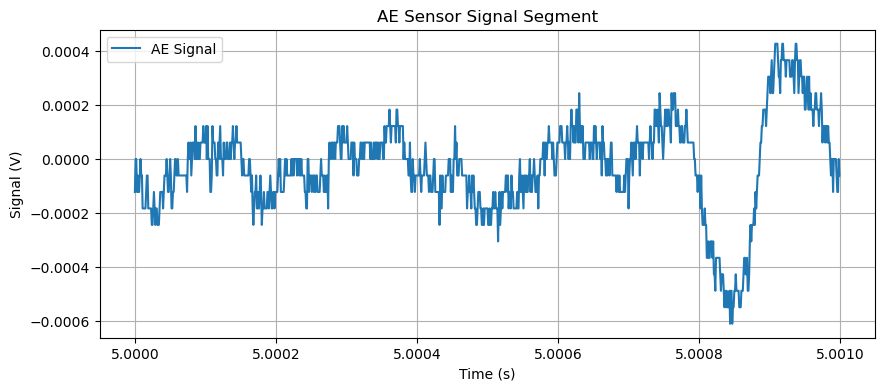

In [ ]:
# Create a mask to select a small timespan of data
mask = (combined_data[:, 0] >= 5) & (combined_data[:, 0] < 5.001)
segment = combined_data[mask]

# Plot the masked segment
plt.figure(figsize=(10, 4))
plt.plot(segment[:, 0], segment[:, 1], label="AE Signal")
plt.xlabel("Time (s)")
plt.ylabel("Signal (V)")
plt.title("AE Sensor Signal Segment")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print(f"Sampling Interval: {sample_interval} s")
sampling_frequency = 1 / sample_interval
print(f"Sampling Frequency: {sampling_frequency} Hz")

Sampling Interval: 1e-06 s
Sampling Frequency: 1000000.0 Hz


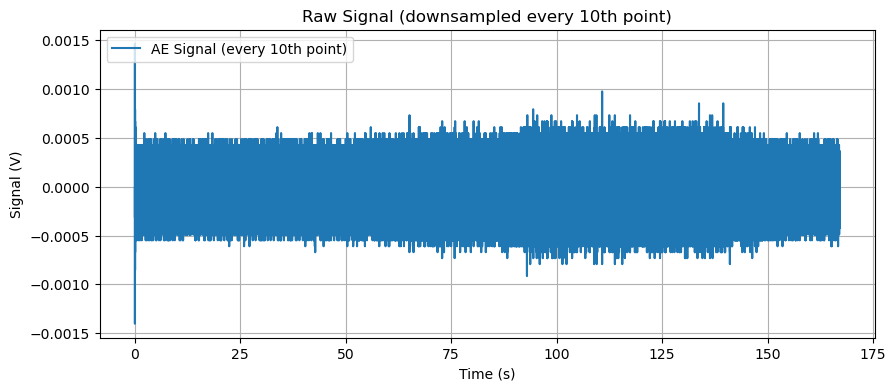

In [ ]:
step: int = 10  # Sample every nth point for downsampling (step = 1 for no downsampling)
x_ds = combined_data[::step, 0]
y_ds = combined_data[::step, 1]

if step == 1:
    label = "AE Signal"
    title = "Raw Signal"
else:
    label = f"AE Signal (every {step}th point)"
    title = f"Raw Signal (downsampled every {step}th point)"

plt.figure(figsize=(10, 4))
plt.plot(x_ds, y_ds, label=label)
plt.xlabel("Time (s)")
plt.ylabel("Signal (V)")
plt.title(title)
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

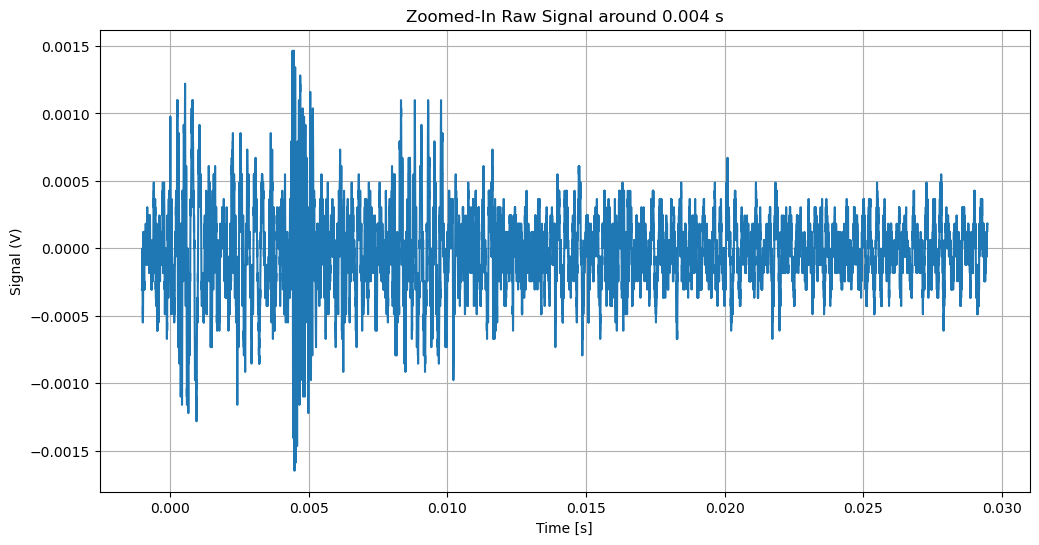

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) find time of max abs signal
idx_max = np.argmax(np.abs(combined_data[:, 1]))
default_center = combined_data[idx_max, 0]

# 2) ask user (Enter to accept default_center)
user_in = input(f"Enter time to center zoom on [s] (default {default_center:.3f}): ").strip()
if user_in:
    try:
        center = float(user_in)
    except ValueError:
        print(f"Invalid input '{user_in}', using default {default_center:.3f}")
        center = default_center
else:
    center = default_center

# 3) define your zoom window (10 ms here)
window = 0.05
half = window / 2

viewing_xmin = center - half
viewing_xmax = center + half

# 4) (optional) clamp to the data’s time range
t0, tN = combined_data[0, 0], combined_data[-1, 0]
viewing_xmin = max(viewing_xmin, t0)
viewing_xmax = min(viewing_xmax, tN)

# 5) extract and plot
mask = (combined_data[:, 0] >= viewing_xmin) & (combined_data[:, 0] < viewing_xmax)
segment = combined_data[mask]

plt.figure(figsize=(12, 6))
plt.plot(segment[:, 0], segment[:, 1])
plt.title(f'Zoomed-In Raw Signal around {center:.3f} s')
plt.xlabel('Time [s]')
plt.ylabel('Signal (V)')
plt.grid(True)
plt.show()


## Time-Mask the AE Signal for Power Spectral Density Analysis (Optional)

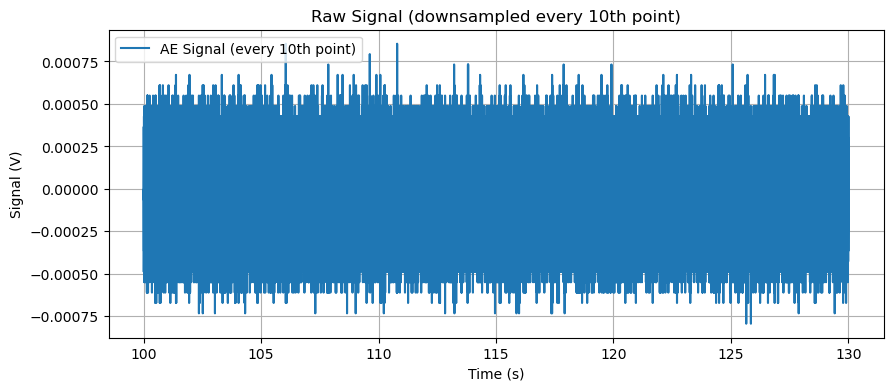

In [ ]:
start_time = 0
end_time = None  # Set to None for no end time

if end_time is not None:
    mask = (combined_data[:, 0] >= start_time) & (combined_data[:, 0] < end_time)
else:
    mask = (combined_data[:, 0] >= start_time)

masked_ae_data = combined_data[mask]

step: int = 10  # Sample every nth point for downsampling (step = 1 for no downsampling)
x_ds = masked_ae_data[::step, 0]
y_ds = masked_ae_data[::step, 1]

if step == 1:
    label = "AE Signal"
    title = "Raw Signal"
else:
    label = f"AE Signal (every {step}th point)"
    title = f"Raw Signal (downsampled every {step}th point)"

plt.figure(figsize=(10, 4))
plt.plot(x_ds, y_ds, label=label)
plt.xlabel("Time (s)")
plt.ylabel("Signal (V)")
plt.title(title)
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

## Power Spectrum

In [ ]:
# # Compute the Signal RMS
# signal_rms = np.sqrt(np.mean(np.square(masked_raw_signal)))
# print(f"Signal RMS: {signal_rms} V")

# Compute the Power Spectral Density (PSD)
psd_frequencies, psd = welch(masked_ae_data[:, 1], fs=sampling_frequency, nperseg=4096)
# Convert PSD to dB Scale
psd_db = 10 * np.log10(psd)

while True:
    save_psd_csv = input("Save Power Spectral Density to CSV? (y/n): ").strip().lower()
    if save_psd_csv in ['y', 'n']:
        break
    print("Invalid input. Please enter 'y' or 'n'.")

if save_psd_csv == 'y':
    # Save to CSV
    df = pd.DataFrame({
        'Frequency (Hz)': psd_frequencies,
        'Power Spectral Density': psd,
        'Power Spectral Density (dB)': psd_db
    })

    # Extract folder name and parent directory
    folder_name = os.path.basename(folder_path)                     # → "PD-acoustic140_wfms"
    parent_path = os.path.dirname(folder_path)                     # → "...\\PD-acoustic140"

    # Construct output filename and path
    output_filename = f"{folder_name}_psd_output.csv"
    output_path = os.path.join(parent_path, output_filename)

    df.to_csv(output_path, index=False)

psd_min = np.min(psd)
psd_max = np.max(psd)

psd_db_min = np.min(psd_db)
psd_db_max = np.max(psd_db)

print(f"Min Power: {psd_db_min} dB")
print(f"Max Power: {psd_db_max} dB")

Min Power: -148.27898053820962 dB
Max Power: -113.1491852573019 dB


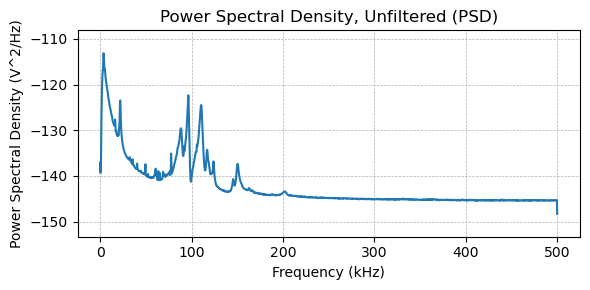

In [ ]:
# Plotting the PSD on a log scale
plt.figure(figsize=(6,3))
# plt.semilogx(psd_frequencies, psd_db)
plt.plot(psd_frequencies/1e3, psd_db)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Power Spectral Density (V^2/Hz)")
plt.ylim([psd_db_min-5, psd_db_max+5])
plt.title("Power Spectral Density, Unfiltered (PSD)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## STFT Spectrogram

In [ ]:
# Compute the spectrogram
frequencies, times, Sxx = spectrogram(masked_ae_data[:, 1], sampling_frequency, nperseg=4096)
Sxx_log = 10 * np.log10(Sxx)

In [ ]:
# Times (s) over which to mask out the x-axis
start_time_mask = None
end_time_mask = None

max_freq = 50e3  # Frequency (Hz) over which to mask out the y-axis

min_spectrogram_value_ctrl = psd_db_min
max_spectrogram_value_ctrl = psd_db_max
print(psd_db_min, psd_db_max)

min_spectrogram_value_ctrl = -150
max_spectrogram_value_ctrl = -110

-148.27898053820962 -113.1491852573019


In [ ]:
freq_mask = frequencies <= max_freq
masked_frequencies = frequencies[freq_mask]
masked_Sxx_log = Sxx_log[freq_mask, :]

# Add the start_time to the times array
times = times + start_time

print(f"Sxx_log shape: {Sxx_log.shape}")
print(f"Masked Sxx_log shape: {masked_Sxx_log.shape}")

# Create the boolean mask for the x-axis
masked_times = times

if start_time_mask is not None and end_time_mask is not None:
    time_mask = (masked_times >= start_time_mask) & (masked_times <= end_time_mask)
elif end_time_mask is not None:
    time_mask = masked_times <= end_time_mask
elif start_time_mask is not None:
    time_mask = masked_times >= start_time_mask
else:
    time_mask = np.ones_like(masked_times, dtype=bool)

# Filter times and spectrogram data based on the time_mask.
masked_times = masked_times[time_mask]
masked_Sxx_log = masked_Sxx_log[:, time_mask]

Sxx_log shape: (2049, 8370)
Masked Sxx_log shape: (205, 8370)


Minimum Spectrogram Power: -150
Maximum Spectrogram Power: -110


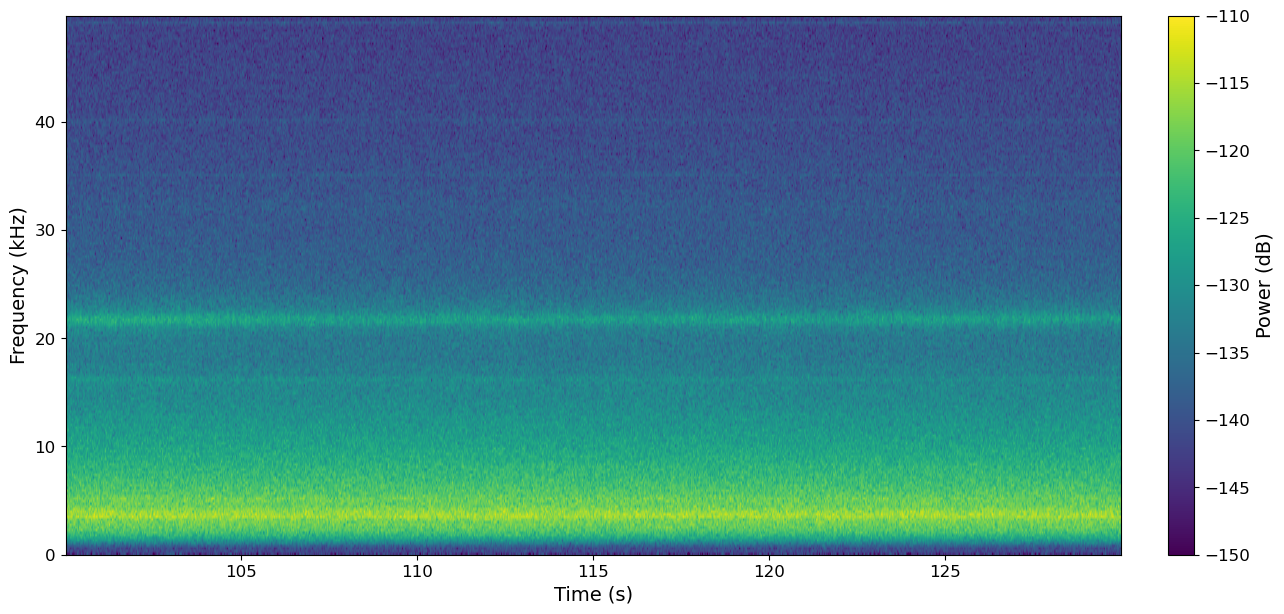

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 7))

label_size=14
tick_size=12

print("Minimum Spectrogram Power:", min_spectrogram_value_ctrl)
print("Maximum Spectrogram Power:", max_spectrogram_value_ctrl)

# TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
spectrogram_image = ax1.imshow(
    masked_Sxx_log, 
    extent=[masked_times[0], masked_times[-1], masked_frequencies[-1]/1e3, masked_frequencies[0]/1e3], 
    interpolation='bilinear', 
    cmap='viridis', 
    aspect='auto', 
    vmin=min_spectrogram_value_ctrl,
    vmax=max_spectrogram_value_ctrl, 
    # origin='lower'
)
ax1.invert_yaxis()

ax1.set_ylabel('Frequency (kHz)', fontsize=label_size)
ax1.set_xlabel('Time (s)', fontsize=label_size)

# Format the y-axis to show whole numbers instead of scientific notation
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

cbar = fig.colorbar(spectrogram_image, ax=[ax1], fraction=0.05, pad=0.04)
cbar.set_label('Power (dB)', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size) 

plt.tick_params(axis='both', which='major', labelsize=tick_size)

In [ ]:
# ----------------------------------------------------------------------
# 1)  ── PRE-COMPUTE A FULL-LENGTH SPECTROGRAM ─────────────────────────
# ----------------------------------------------------------------------
vmin        = min_spectrogram_value_ctrl   # robust global limits
vmax        = max_spectrogram_value_ctrl

# ----------------------------------------------------------------------
# 2)  ── ASK THE USER IF THEY WANT A VIDEO ─────────────────────────────
# ----------------------------------------------------------------------
while True:
    make_video = input("Generate sliding-window spectrogram video? (y/n): ").strip().lower()
    if make_video in ("y", "n"):
        break
    print("Please enter 'y' or 'n'.")

if make_video == "n":
    raise SystemExit("OK – nothing to do.")

# ----------------------------------------------------------------------
# 3)  ── VIDEO SETTINGS YOU MAY TWEAK ──────────────────────────────────
# ----------------------------------------------------------------------
FPS         = 4            # video frame-rate
WINDOW_LEN  = 2.0          # seconds shown in each frame
STEP        = 0.5          # seconds between two successive frames
DPI         = 150
OUTFILE     = f"spectrogram_{WINDOW_LEN}swin_{STEP}sstep_{FPS}fps.mp4"

# ----------------------------------------------------------------------
# 4)  ── STATIC FIGURE/AXES BOILERPLATE (done once) ────────────────────
# ----------------------------------------------------------------------
mpl.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(figsize=(16, 7), dpi=DPI)

# dummy 2-D array so that imshow exists before the first update()
im = ax.imshow(
    np.zeros((len(masked_frequencies), 1)),
    extent=[0, WINDOW_LEN, masked_frequencies[-1]/1e3, masked_frequencies[0]/1e3],
    interpolation="bilinear",
    cmap="viridis",
    aspect="auto",
    vmin=vmin, vmax=vmax,
    origin="lower",
)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (kHz)")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.04)
cbar.set_label("Power (dB)")
plt.subplots_adjust(right=0.88)

# ----------------------------------------------------------------------
# 5)  ── ANIMATION CORE ────────────────────────────────────────────────
# ----------------------------------------------------------------------
def frame_gen():
    """Yield successive (mask, start_time) pairs covering the whole clip."""
    starts = np.arange(times[0], times[-1] - WINDOW_LEN + 1e-9, STEP)
    for s in starts:
        col_mask = (times >= s) & (times < s + WINDOW_LEN)
        yield col_mask, s

def update(frame):
    col_mask, s = frame
    if not np.any(col_mask):
        return (im,)                           # empty window – skip

    window_img = masked_Sxx_log[:, col_mask]          # slice columns only
    im.set_data(window_img)
    im.set_extent([s, s + WINDOW_LEN, masked_frequencies[0], masked_frequencies[-1]])
    ax.set_title(f"Sliding-window spectrogram   $t = {s:6.2f}$–{s + WINDOW_LEN:6.2f} s")
    return (im,)

anim = animation.FuncAnimation(
    fig, update, frames=frame_gen(), blit=False, interval=1000 / FPS
)

# ----------------------------------------------------------------------
# 6)  ── SAVE TO DISK (requires ffmpeg in PATH) ────────────────────────
# ----------------------------------------------------------------------
writer = animation.FFMpegWriter(fps=FPS, bitrate=1800)
anim.save(OUTFILE, writer=writer)
print(f"Video written to {OUTFILE}")


SystemExit: OK – nothing to do.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cv2
import os
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg

In [ ]:
def create_spectrogram_sliding_window_video_optimized(spectrogram, t, frqs, 
                                                    min_spectrogram_value_ctrl, max_spectrogram_value_ctrl,
                                                    window_size_seconds=2.0, playback_speed=1.0, fps=30,
                                                    output_filename='spectrogram_video.mp4',
                                                    cmap='viridis', figure_width=1600, figure_height=700,
                                                    label_size=14, tick_size=12):
    """
    Create a sliding window video from spectrogram data with time and frequency information - optimized version
    
    Parameters:
    -----------
    spectrogram : numpy.ndarray
        The spectrogram data
    t : numpy.ndarray
        Time values
    frqs : numpy.ndarray
        Frequency values
    min_spectrogram_value_ctrl, max_spectrogram_value_ctrl : float
        Min and max values for spectrogram color mapping
    window_size_seconds : float, optional
        Size of the viewing window in seconds
    playback_speed : float, optional
        Speed multiplier for playback (e.g., 2.0 means the video advances 2 seconds of data per 1 second of playback)
    fps : int, optional
        Frames per second of the output video
    output_filename : str, optional
        Path to save the output video
    cmap : str, optional
        Colormap for the spectrogram
    figure_width, figure_height : int, optional
        Dimensions of the output video in pixels
    label_size, tick_size : int, optional
        Font sizes for labels and ticks
    """
    # Calculate step size based on playback speed and fps
    step_size_seconds = playback_speed / fps
    
    # Calculate window size and step size in time indices
    time_resolution = t[1] - t[0]
    window_size_indices = int(window_size_seconds / time_resolution)
    step_size_indices = max(1, int(step_size_seconds / time_resolution))
    
    # Calculate the number of frames
    num_frames = (len(t) - window_size_indices) // step_size_indices + 1
    
    # Calculate video dimensions
    video_width = figure_width
    video_height = figure_height
    
    # Height of the overview
    overview_height = int(video_height * 0.15)
    main_height = video_height - overview_height - 10  # 10px padding
    
    # Initialize the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1' for h.264
    video = cv2.VideoWriter(output_filename, fourcc, fps, (video_width, video_height))
    
    # ============ KEY OPTIMIZATION: Pre-render the overview only once ============
    print("Creating overview spectrogram...")
    fig_overview, ax_overview = plt.subplots(figsize=(video_width/100, overview_height/100), dpi=100)
    overview_img = ax_overview.imshow(
        spectrogram,
        extent=[t[0], t[-1], frqs[-1], frqs[0]],
        interpolation='bilinear',
        cmap=cmap,
        aspect='auto',
        vmin=min_spectrogram_value_ctrl,
        vmax=max_spectrogram_value_ctrl
    )
    ax_overview.invert_yaxis()
    ax_overview.set_xlabel('Time (s)', fontsize=tick_size-2)
    ax_overview.tick_params(axis='both', which='major', labelsize=tick_size-2)
    plt.tight_layout()
    
    # Convert to image directly using FigureCanvasAgg (faster than savefig)
    canvas = FigureCanvasAgg(fig_overview)
    canvas.draw()
    overview_array = np.array(canvas.buffer_rgba())[:, :, :3]
    overview_img = cv2.cvtColor(overview_array, cv2.COLOR_RGB2BGR)
    plt.close(fig_overview)
    
    # Resize to fit the video dimensions
    overview_img = cv2.resize(overview_img, (video_width, overview_height))
    
    # ============ KEY OPTIMIZATION: Create and reuse a single figure for all frames ============
    print("Creating template for main window...")
    # Create the main window template figure and axes - will be reused for all frames
    fig, ax = plt.subplots(figsize=(figure_width/100, main_height/100), dpi=100)
    
    # Create the initial imshow object - we'll update its data for each frame
    img = ax.imshow(
        spectrogram[:, :window_size_indices],
        extent=[t[0], t[window_size_indices], frqs[-1], frqs[0]],
        interpolation='bilinear',
        cmap=cmap,
        aspect='auto',
        vmin=min_spectrogram_value_ctrl,
        vmax=max_spectrogram_value_ctrl
    )
    ax.invert_yaxis()
    
    # Set up all the static elements that don't change between frames
    ax.set_ylabel('Frequency (Hz)', fontsize=label_size)
    ax.set_xlabel('Time (s)', fontsize=label_size)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    cbar = fig.colorbar(img, ax=ax, fraction=0.05, pad=0.04)
    cbar.set_label('Power (dB)', fontsize=label_size)
    cbar.ax.tick_params(labelsize=tick_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
    
    # Create a title object that we'll update for each frame
    title = ax.set_title('', fontsize=label_size+2)
    
    # Prepare the canvas for fast rendering
    canvas = FigureCanvasAgg(fig)
    
    # Create frames with simple inline progress bar
    print(f"Creating {num_frames} frames...")
    import sys
    
    # Function to create a simple inline progress bar
    def print_progress_bar(current, total, bar_length=50):
        percent = float(current) * 100 / total
        arrow = '=' * int(percent / 100 * bar_length - 1) + '>'
        spaces = ' ' * (bar_length - len(arrow))
        
        sys.stdout.write(f"\rProgress: [{arrow}{spaces}] {percent:.1f}% ({current}/{total})")
        sys.stdout.flush()
    
    for frame_idx in range(num_frames):
        # Update the progress bar
        print_progress_bar(frame_idx + 1, num_frames)
        
        # Calculate window indices and times
        start_idx = frame_idx * step_size_indices
        end_idx = min(start_idx + window_size_indices, len(t) - 1)
        start_time = t[start_idx]
        end_time = t[end_idx]
        
        # ============ KEY OPTIMIZATION: Update only what changes ============
        # Update the image data
        img.set_data(spectrogram[:, start_idx:end_idx])
        
        # Update the extent to match the current window
        img.set_extent([start_time, end_time, frqs[-1], frqs[0]])
        
        # Update the title
        title.set_text(f'Window: {start_time:.2f}s - {end_time:.2f}s')
        
        # ============ KEY OPTIMIZATION: Fast rendering ============
        # Redraw the canvas (much faster than savefig)
        canvas.draw()
        
        # Convert to numpy array directly (no file I/O)
        main_array = np.array(canvas.buffer_rgba())[:, :, :3]
        main_img = cv2.cvtColor(main_array, cv2.COLOR_RGB2BGR)
        
        # Resize to fit the video dimensions
        main_img = cv2.resize(main_img, (video_width, main_height))
        
        # Create a blank frame for this iteration
        frame = np.zeros((video_height, video_width, 3), dtype=np.uint8)
        
        # Add main spectrogram window to frame
        frame[:main_height, :] = main_img
        
        # Add overview to bottom of frame
        frame[main_height+10:, :] = overview_img
        
        # Calculate the position of the current window in the overview
        total_time_span = t[-1] - t[0]
        window_start_ratio = (start_time - t[0]) / total_time_span
        window_end_ratio = (end_time - t[0]) / total_time_span
        
        overview_start_x = int(window_start_ratio * video_width)
        overview_end_x = int(window_end_ratio * video_width)
        
        # Draw rectangle on the overview to show current window position
        cv2.rectangle(frame, 
                     (overview_start_x, main_height+10), 
                     (overview_end_x, video_height), 
                     (0, 255, 0), 2)
        
        # Write the frame to the video
        video.write(frame)
    
    # Print a newline after the progress bar is complete
    print()
    
    # Clean up
    plt.close(fig)
    video.release()
    
    print(f"Video saved as '{output_filename}'")
    return output_filename

# Example usage
if __name__ == "__main__":   
    print("Creating video...")
    video_path = create_spectrogram_sliding_window_video_optimized(
        spectrogram=masked_Sxx_log,
        t=times,
        frqs=masked_frequencies,
        min_spectrogram_value_ctrl=min_spectrogram_value_ctrl,
        max_spectrogram_value_ctrl=max_spectrogram_value_ctrl,
        window_size_seconds=10.0,      # Size of the window in seconds
        playback_speed=6,            # Playback speed (x times faster than real-time)
        fps=5,                        # Frames per second
        output_filename='custom_spectrogram_sliding_window_optimized.mp4',
        cmap='viridis',                # Match your original colormap
        figure_width=1600,             # Width of the figure in pixels
        figure_height=700,             # Height of the figure in pixels
        label_size=14,                 # Size of axis labels
        tick_size=12                   # Size of tick labels
    )
    
    print(f"Video created at: {os.path.abspath(video_path)}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
import os
from tqdm import tqdm
import matplotlib

# Force matplotlib to use a specific backend for video writing
matplotlib.use('Agg')

def create_sample_spectrogram(time_bins=1000, freq_bins=256):
    """
    Create a sample spectrogram if no data is provided
    
    Parameters:
    -----------
    time_bins : int
        Number of time bins (width of spectrogram)
    freq_bins : int
        Number of frequency bins (height of spectrogram)
        
    Returns:
    --------
    numpy.ndarray
        Sample spectrogram data
    """
    # Create a base matrix
    spec = np.random.rand(freq_bins, time_bins) * 0.1
    
    # Add some "features" to make it look more like a real spectrogram
    # Add harmonics (horizontal lines)
    for i in range(1, 6):
        pos = np.random.randint(10, freq_bins-20)
        spec[pos:pos+3, :] += np.random.rand() * 0.8
    
    # Add some transients (vertical lines)
    for i in range(15):
        pos = np.random.randint(0, time_bins)
        width = np.random.randint(1, 5)
        spec[:, pos:pos+width] += np.random.rand() * 0.3
        
    # Add some "notes" (diagonal patterns)
    for i in range(10):
        start_time = np.random.randint(0, time_bins-100)
        end_time = start_time + np.random.randint(50, 100)
        start_freq = np.random.randint(0, freq_bins-20)
        end_freq = start_freq + np.random.randint(-20, 20)
        
        # Create diagonal line
        times = np.linspace(start_time, end_time, end_time-start_time).astype(int)
        freqs = np.linspace(start_freq, end_freq, end_time-start_time).astype(int)
        for t, f in zip(times, freqs):
            if 0 <= f < freq_bins and 0 <= t < time_bins:
                spec[f:f+5, t] += 0.7
    
    # Apply some smoothing
    from scipy.ndimage import gaussian_filter
    spec = gaussian_filter(spec, sigma=1)
    
    # Normalize
    spec = (spec - spec.min()) / (spec.max() - spec.min())
    
    return spec

def create_sliding_window_video_original(spectrogram, window_size=100, step_size=1, fps=30, 
                               output_filename='spectrogram_video.mp4', dpi=100,
                               cmap='viridis', figsize=(10, 8), codec='h264'):
    """
    Create a sliding window video from a spectrogram numpy array using matplotlib's animation
    
    Parameters:
    -----------
    spectrogram : numpy.ndarray
        2D array containing the spectrogram data, shape (frequency_bins, time_bins)
    window_size : int
        Width of the sliding window in time bins
    step_size : int
        Number of time bins to advance the window in each frame
    fps : int
        Frames per second in the output video
    output_filename : str
        Name of the output video file
    dpi : int
        Resolution of the output video
    cmap : str
        Matplotlib colormap to use
    figsize : tuple
        Figure size (width, height) in inches
    codec : str
        Video codec to use (h264, mpeg4, etc.)
        
    Returns:
    --------
    str
        Path to the created video file
    """
    freq_bins, time_bins = spectrogram.shape
    
    # Create the figure with two subplots - main view and overview
    fig = plt.figure(figsize=figsize)
    
    # Setup layout grid - main view takes 80% of height, overview takes 15%
    grid = plt.GridSpec(20, 1, hspace=0.3)
    ax_main = fig.add_subplot(grid[:16, 0])  # Main view - top 80%
    ax_overview = fig.add_subplot(grid[17:, 0])  # Overview - bottom 15%
    
    # Calculate the number of frames
    num_frames = (time_bins - window_size) // step_size + 1
    
    # Initial plot for main view
    vmin, vmax = np.min(spectrogram), np.max(spectrogram)
    main_img = ax_main.imshow(spectrogram[:, 0:window_size], 
                   aspect='auto', 
                   origin='lower',
                   cmap=cmap,
                   vmin=vmin,
                   vmax=vmax,
                   extent=[0, window_size, 0, freq_bins])
    
    # Add colorbar to main view
    plt.colorbar(main_img, ax=ax_main, label='Amplitude')
    
    # Set labels for main view
    ax_main.set_xlabel('Time (frames)')
    ax_main.set_ylabel('Frequency (bins)')
    ax_main.set_title('Spectrogram Sliding Window')
    
    # Plot the full spectrogram in the overview (this stays static)
    overview_img = ax_overview.imshow(spectrogram, 
                          aspect='auto', 
                          origin='lower',
                          cmap=cmap,
                          vmin=vmin,
                          vmax=vmax,
                          extent=[0, time_bins, 0, freq_bins])
    
    # Set minimal labels for overview
    ax_overview.set_xlabel('Full Spectrogram')
    ax_overview.set_yticks([])  # No y ticks for overview
    
    # Create a rectangle patch for the window indicator (will be updated in each frame)
    from matplotlib.patches import Rectangle
    window_rect = Rectangle((0, 0), window_size, freq_bins, 
                           fill=False, edgecolor='lime', linestyle='-', linewidth=2)
    ax_overview.add_patch(window_rect)
    
    # Animation update function
    def update(frame):
        start_idx = frame * step_size
        end_idx = start_idx + window_size
        
        # Update the main image data
        main_img.set_array(spectrogram[:, start_idx:end_idx])
        
        # Update the extent to reflect the current window position
        main_img.set_extent([start_idx, end_idx, 0, freq_bins])
        
        # Update the title to show current position
        ax_main.set_title(f'Spectrogram Sliding Window (Position: {start_idx}-{end_idx})')
        
        # Update the rectangle position in the overview
        window_rect.set_xy((start_idx, 0))
        
        return [main_img, window_rect]
    
    # Create the animation
    print(f"Creating animation with {num_frames} frames...")
    anim = FuncAnimation(fig, update, frames=tqdm(range(num_frames)), blit=True)
    
    # Set up the writer with explicit codec
    if codec == 'h264':
        # Try first with h264 codec (best quality and compatibility)
        try:
            from matplotlib.animation import FFMpegWriter
            writer = FFMpegWriter(fps=fps, codec='h264', 
                                bitrate=3000,
                                extra_args=['-pix_fmt', 'yuv420p'])  # For compatibility
        except Exception as e:
            print(f"Warning: Could not use h264 codec: {e}")
            print("Falling back to mpeg4 codec")
            writer = FFMpegWriter(fps=fps, codec='mpeg4')
    else:
        # Use specified codec
        from matplotlib.animation import FFMpegWriter
        writer = FFMpegWriter(fps=fps, codec=codec)
    
    # Save the animation
    print(f"Saving video with {num_frames} frames at {fps} fps...")
    anim.save(output_filename, writer=writer, dpi=dpi)
    plt.close(fig)
    
    print(f"Video saved as '{output_filename}'")
    return output_filename

# Function to create a time-based spectrogram video - mimics the user's original spectrogram style
def create_spectrogram_sliding_window_time(masked_Sxx_log, times, masked_frequencies, 
                                         min_spectrogram_value_ctrl, max_spectrogram_value_ctrl,
                                         window_size_seconds=2.0, step_size_seconds=0.1, fps=30, 
                                         output_filename='spectrogram_time_video.mp4', dpi=100,
                                         cmap='viridis', figsize=(10, 8), codec='h264'):
    """
    Create a sliding window video from a spectrogram with time axis
    
    Parameters:
    -----------
    masked_Sxx_log : numpy.ndarray
        2D array containing the spectrogram data
    times : numpy.ndarray
        Array of time values (x-axis)
    masked_frequencies : numpy.ndarray
        Array of frequency values (y-axis)
    min_spectrogram_value_ctrl, max_spectrogram_value_ctrl : float
        Min and max values for colormap scaling
    window_size_seconds : float
        Width of the sliding window in seconds
    step_size_seconds : float
        Number of seconds to advance the window in each frame
    fps, output_filename, dpi, cmap, figsize : same as above
    codec : str
        Video codec to use (h264, mpeg4, etc.)
    """
    # Calculate window size and step size in time indices
    time_resolution = times[1] - times[0]
    window_size_indices = int(window_size_seconds / time_resolution)
    step_size_indices = max(1, int(step_size_seconds / time_resolution))
    
    # Create the figure with two subplots - main view and overview
    fig = plt.figure(figsize=figsize)
    
    # Setup layout grid - main view takes 80% of height, overview takes 15%
    grid = plt.GridSpec(20, 1, hspace=0.3)
    ax_main = fig.add_subplot(grid[:16, 0])  # Main view - top 80%
    ax_overview = fig.add_subplot(grid[17:, 0])  # Overview - bottom 15%
    
    # Calculate the number of frames
    num_frames = (len(times) - window_size_indices) // step_size_indices + 1
    
    # Initial plot for main view
    start_time = times[0]
    end_time = times[window_size_indices]
    
    main_img = ax_main.imshow(masked_Sxx_log[:, 0:window_size_indices], 
                   aspect='auto', 
                   origin='lower',
                   cmap=cmap,
                   vmin=min_spectrogram_value_ctrl,
                   vmax=max_spectrogram_value_ctrl,
                   extent=[start_time, end_time, masked_frequencies[-1], masked_frequencies[0]])
    
    # Invert y-axis (frequencies)
    ax_main.invert_yaxis()
    
    # Add colorbar to main view
    cbar = plt.colorbar(main_img, ax=ax_main, label='Power (dB)')
    
    # Set labels for main view
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Frequency (Hz)')
    ax_main.set_title('Spectrogram Sliding Window')
    
    # Format the y-axis to show whole numbers
    from matplotlib.ticker import FuncFormatter
    ax_main.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    
    # Plot the full spectrogram in the overview (this stays static)
    overview_img = ax_overview.imshow(masked_Sxx_log, 
                          aspect='auto', 
                          origin='lower',
                          cmap=cmap,
                          vmin=min_spectrogram_value_ctrl,
                          vmax=max_spectrogram_value_ctrl,
                          extent=[times[0], times[-1], masked_frequencies[-1], masked_frequencies[0]])
    
    # Invert y-axis for overview
    ax_overview.invert_yaxis()
    
    # Set minimal labels for overview
    ax_overview.set_xlabel('Full Spectrogram')
    ax_overview.set_yticks([])  # No y ticks for overview
    
    # Create a rectangle patch for the window indicator (will be updated in each frame)
    from matplotlib.patches import Rectangle
    window_rect = Rectangle((start_time, masked_frequencies[-1]), 
                          window_size_seconds, 
                          masked_frequencies[0] - masked_frequencies[-1], 
                          fill=False, edgecolor='lime', linestyle='-', linewidth=2)
    ax_overview.add_patch(window_rect)
    
    # Animation update function
    def update(frame):
        start_idx = frame * step_size_indices
        end_idx = min(start_idx + window_size_indices, len(times) - 1)
        
        # Calculate window times
        start_time = times[start_idx]
        end_time = times[end_idx]
        
        # Update the main image data
        main_img.set_array(masked_Sxx_log[:, start_idx:end_idx])
        
        # Update the extent to reflect the current window position
        main_img.set_extent([start_time, end_time, masked_frequencies[-1], masked_frequencies[0]])
        
        # Update the title to show current position
        ax_main.set_title(f'Spectrogram Window: {start_time:.2f}s - {end_time:.2f}s')
        
        # Update the rectangle position in the overview
        window_rect.set_xy((start_time, masked_frequencies[-1]))
        window_rect.set_width(end_time - start_time)
        
        return [main_img, window_rect]
    
    # Create the animation
    print(f"Creating animation with {num_frames} frames...")
    anim = FuncAnimation(fig, update, frames=tqdm(range(num_frames)), blit=True)
    
    # Set up the writer with explicit codec
    if codec == 'h264':
        # Try first with h264 codec (best quality and compatibility)
        try:
            from matplotlib.animation import FFMpegWriter
            writer = FFMpegWriter(fps=fps, codec='h264', 
                                bitrate=3000,
                                extra_args=['-pix_fmt', 'yuv420p'])  # For compatibility
        except Exception as e:
            print(f"Warning: Could not use h264 codec: {e}")
            print("Falling back to mpeg4 codec")
            writer = FFMpegWriter(fps=fps, codec='mpeg4')
    else:
        # Use specified codec
        from matplotlib.animation import FFMpegWriter
        writer = FFMpegWriter(fps=fps, codec=codec)
    
    # Save the animation
    print(f"Saving video with {num_frames} frames at {fps} fps...")
    anim.save(output_filename, writer=writer, dpi=dpi)
    plt.close(fig)
    
    print(f"Video saved as '{output_filename}'")
    return output_filename

def create_example_data():
    """
    Create example data similar to what the user might have
    """
    # Time and frequency ranges
    duration = 10.0  # seconds
    time_resolution = 0.01  # seconds
    times = np.arange(0, duration, time_resolution)
    frequencies = np.linspace(0, 5000, 256)
    
    # Create a spectrogram (simplified example)
    spectrogram = np.zeros((len(frequencies), len(times)))
    
    # Add some features
    # Base noise
    spectrogram += np.random.rand(len(frequencies), len(times)) * 0.1
    
    # Add a chirp (increasing frequency over time)
    for t_idx, t in enumerate(times):
        freq_idx = int((t / duration) * len(frequencies) * 0.8)
        if freq_idx < len(frequencies):
            width = 5
            spectrogram[max(0, freq_idx-width):min(len(frequencies), freq_idx+width), t_idx] += 0.8 * np.exp(-0.5 * np.arange(-width, width)**2 / 5)
    
    # Add some harmonics
    for harmonic in [2, 3, 4]:
        for t_idx, t in enumerate(times):
            freq_idx = int((t / duration) * len(frequencies) * 0.8 / harmonic)
            if freq_idx < len(frequencies):
                width = 3
                spectrogram[max(0, freq_idx-width):min(len(frequencies), freq_idx+width), t_idx] += (0.8 / harmonic) * np.exp(-0.5 * np.arange(-width, width)**2 / 3)
    
    # Add some transients
    for _ in range(5):
        t_idx = np.random.randint(0, len(times))
        width_t = np.random.randint(10, 30)
        for i in range(-width_t, width_t):
            if 0 <= t_idx + i < len(times):
                spectrogram[:100, t_idx+i] += 0.5 * np.exp(-0.5 * i**2 / 100)
    
    # Convert to log scale (dB) with some offset to avoid log(0)
    spectrogram = 10 * np.log10(spectrogram + 1e-10)
    
    # Set min and max values for display
    min_val = np.percentile(spectrogram, 5)
    max_val = np.percentile(spectrogram, 95)
    
    return spectrogram, times, frequencies, min_val, max_val


# Example usage
if __name__ == "__main__":
    # Generate a sample spectrogram with index numbers
    print("Generating sample spectrogram...")
    spec = create_sample_spectrogram(time_bins=1000, freq_bins=256)
    
    # Create the sliding window video with the original approach
    video_path = create_sliding_window_video_original(
        spec,
        window_size=200,       # Size of the window in time bins
        step_size=5,           # How many bins to move per frame
        fps=30,                # Frames per second
        output_filename='spectrogram_sliding_window_original.mp4',
        cmap='viridis',
        figsize=(10, 8),
        codec='mpeg4'         # Try 'mpeg4' if 'h264' doesn't work
    )
    
    print(f"Video created at: {os.path.abspath(video_path)}")
    
    # # Now create a time-based example
    # print("\nCreating time-based example data...")
    
    # # Create the time-based sliding window video
    # video_path_time = create_spectrogram_sliding_window_time(
    #     masked_Sxx_log=masked_Sxx_log,
    #     times=times,
    #     masked_frequencies=masked_frequencies,
    #     min_spectrogram_value_ctrl=min_spectrogram_value_ctrl,
    #     max_spectrogram_value_ctrl=max_spectrogram_value_ctrl,
    #     window_size_seconds=2.0,
    #     step_size_seconds=0.1,
    #     fps=30,
    #     output_filename='spectrogram_sliding_window_time.mp4',
    #     cmap='viridis',
    #     figsize=(10, 8),
    #     codec='mpeg4'          # Try 'mpeg4' if 'h264' doesn't work
    # )
    
    # print(f"Time-based video created at: {os.path.abspath(video_path_time)}")

In [ ]:
# # Create figure and axes objects
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot the spectrogram using axes object
# pcm = ax.pcolormesh(times, masked_frequencies, masked_Sxx_log, 
#                     shading='gouraud', 
#                     vmin=min_spectrogram_value_ctrl, 
#                     vmax=max_spectrogram_value_ctrl)

# # Set axis limits and labels
# ax.set_ylabel('Frequency [Hz]', fontsize=14)
# ax.set_xlabel('Time [s]', fontsize=14)

# # Set title
# ax.set_title(f'{base_folder_name} Spectrogram', fontsize=16)

# # Set tick parameters
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Add colorbar
# fig.colorbar(pcm, ax=ax, label='Intensity [dB]')

# # Adjust layout
# fig.tight_layout()

# # Show the plot
# plt.show()

## Zoomed-In Spectrogram

In [ ]:
# Times (s) over which to mask out the x-axis
start_time_mask = 100
end_time_mask = 100.5

# Range (Hz) over which to mask out the y-axis
max_freq = 50e3

# Create the boolean mask for the x-axis
time_mask = (times >= start_time_mask) & (times <= end_time_mask)

# Create the boolean mask for the y-axis
freq_mask = frequencies <= max_freq

# Filter times and spectrogram data based on the time_mask.
masked_times = times[time_mask]
masked_frequencies = frequencies[freq_mask]
masked_Sxx_log = Sxx_log[:, time_mask]
masked_Sxx_log = masked_Sxx_log[freq_mask, :]

In [ ]:
# # Create figure and axes objects 
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot the masked section of the spectrogram using pcolormesh
# pcm = ax.pcolormesh(
#     masked_times, masked_frequencies, masked_Sxx_log, 
#     shading='gouraud', 
#     vmin=min_spectrogram_value_ctrl, 
#     vmax=max_spectrogram_value_ctrl
# )

# # Set axis limits and labels
# ax.set_ylabel('Frequency [Hz]', fontsize=14)
# ax.set_xlabel('Time [s]', fontsize=14)

# # Set title
# ax.set_title(f'{base_folder_name} Spectrogram', fontsize=16)

# # Set tick parameters
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Add colorbar
# fig.colorbar(pcm, ax=ax, label='Intensity [dB]')

# # Adjust layout
# fig.tight_layout()

# # Show the plot
# plt.show()

-148.34335174312497
-113.67366248269221
[    0.       976.5625  1953.125   2929.6875  3906.25    4882.8125
  5859.375   6835.9375  7812.5     8789.0625  9765.625  10742.1875
 11718.75   12695.3125 13671.875  14648.4375 15625.     16601.5625
 17578.125  18554.6875 19531.25   20507.8125 21484.375  22460.9375
 23437.5    24414.0625 25390.625  26367.1875 27343.75   28320.3125
 29296.875  30273.4375 31250.     32226.5625 33203.125  34179.6875
 35156.25   36132.8125 37109.375  38085.9375 39062.5    40039.0625
 41015.625  41992.1875 42968.75   43945.3125 44921.875  45898.4375
 46875.     47851.5625 48828.125  49804.6875]


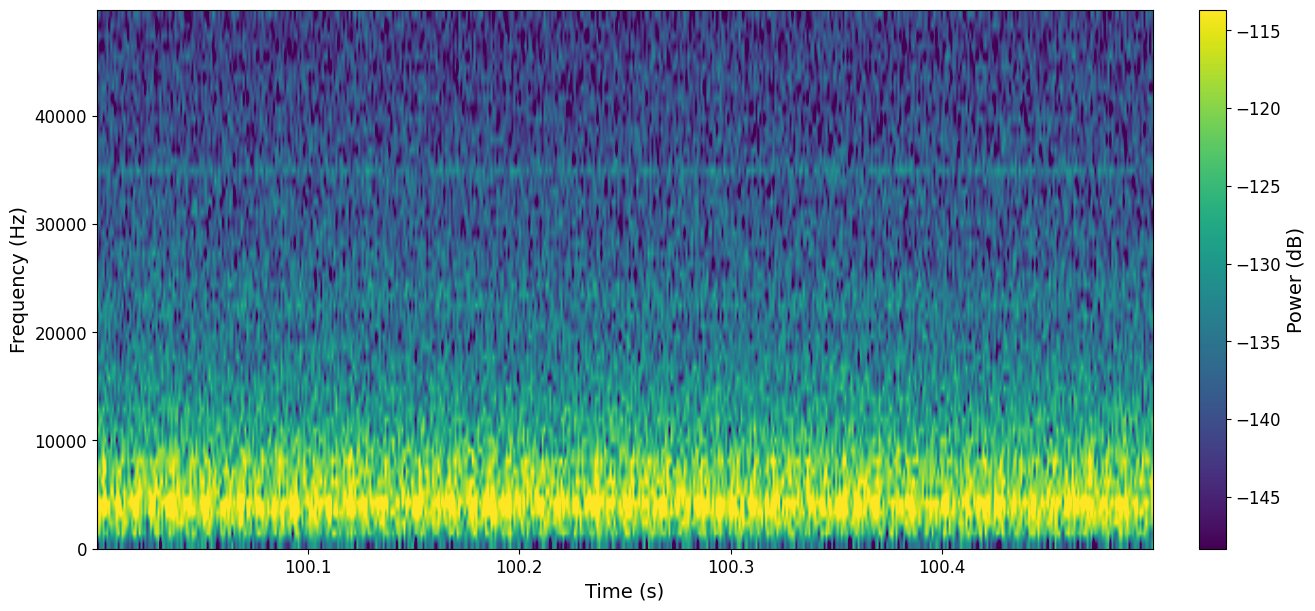

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 7))

label_size=14
tick_size=12

print(min_spectrogram_value_ctrl)
print(max_spectrogram_value_ctrl)

# TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
scalogram_image = ax1.imshow(
    masked_Sxx_log, 
    extent=[masked_times[0], masked_times[-1], masked_frequencies[-1], masked_frequencies[0]], 
    interpolation='bilinear', 
    cmap='viridis', 
    aspect='auto', 
    vmin=min_spectrogram_value_ctrl,
    vmax=max_spectrogram_value_ctrl, 
    # origin='lower'
)
ax1.invert_yaxis()

print(masked_frequencies)

ax1.set_ylabel('Frequency (Hz)', fontsize=label_size)
ax1.set_xlabel('Time (s)', fontsize=label_size)

# Format the y-axis to show whole numbers instead of scientific notation
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

cbar = fig.colorbar(scalogram_image, ax=[ax1], fraction=0.05, pad=0.04)
cbar.set_label('Power (dB)', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size) 

plt.tick_params(axis='both', which='major', labelsize=tick_size)

## Checkpoint Before Proceeding with CWT/DWT Analysis

In [ ]:
try:
    while True:
        user_input = input("Do you want to run CWT/DWT Analysis? Type 'Y/n' to continue: ")
        if user_input.lower() == 'n':
            raise Exception("Execution stopped by user.")
        elif user_input.lower() == 'y':
            break
except Exception as e:
    print(e)
    # Prevent further cells from executing
    raise

## Generate a Synthetic Signal Based on the Power Spectrum of the Time-Masked Raw Signal to Compare Spectrogram Results with

Duration: 149.225471
[16.39717177 16.39714486 16.39711795 ...  0.32773495  0.32773383
  0.32773271]
[-0.95333378-0.30191837j -0.21698192-0.97617562j -0.79868996-0.60174275j
 ... -0.58583476+0.81043053j -0.90587168+0.42355224j
 -0.93869723-0.34474269j]
[6.19428451e-12 2.05012307e-11 1.38636501e-10 3.40067700e-10
 3.01231442e-10 1.39511848e-10 8.89197392e-11 9.21474903e-11
 1.06945583e-10 1.06844150e-10 8.15365026e-11 7.34732352e-11
 8.05452402e-11 6.56877658e-11 4.09398306e-11 3.98106474e-11
 4.96415641e-11 4.44462830e-11 4.06923389e-11 4.86565652e-11
 6.40531064e-11 8.76866394e-11 8.70622228e-11 4.79946823e-11
 1.64301156e-11 7.24711363e-12 6.48018236e-12 6.88904849e-12
 6.28136778e-12 4.19105927e-12 2.23852198e-12 1.30860518e-12
 1.25526956e-12 1.56327843e-12 1.78441921e-12 1.88152359e-12
 1.72829482e-12 1.34154709e-12 9.46211526e-13 6.84222657e-13
 4.99682151e-13 3.46174108e-13 2.70411433e-13 2.60086847e-13
 2.63749268e-13 2.43628113e-13 2.15960353e-13 1.97975226e-13
 1.95924080e-13 

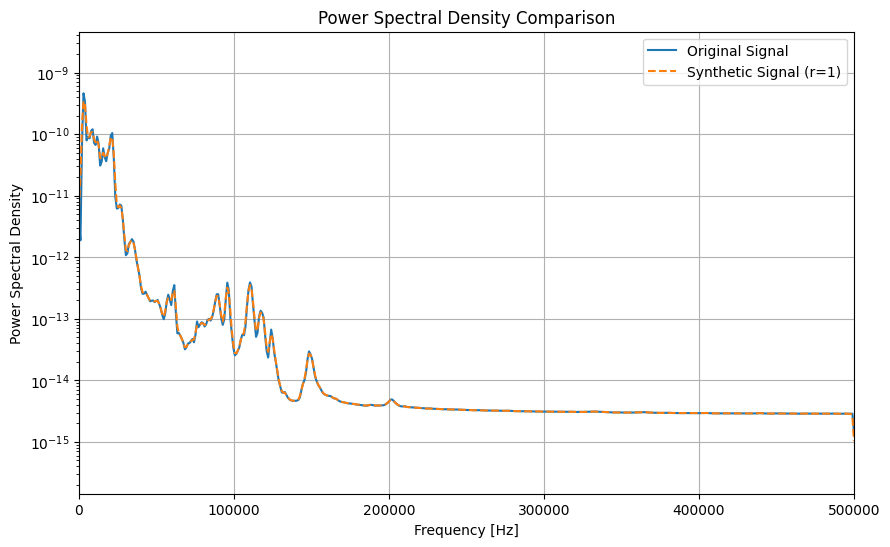

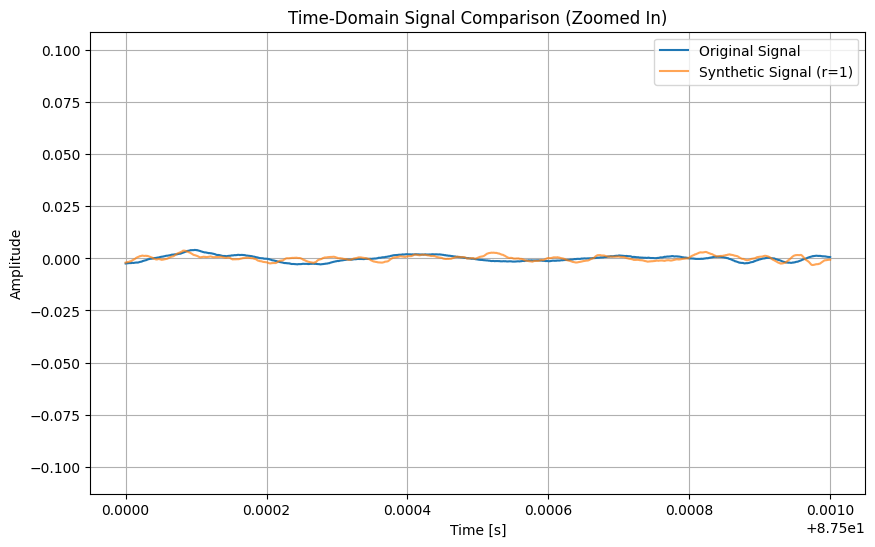

In [ ]:
# Define the resolution factor
r = 1  # Change 'r' to your desired resolution factor

# Original signal parameters
N = len(masked_ae_data)
dt = 1. / sampling_frequency

duration = np.max(masked_ae_data[:, 0])
print(f"Duration: {duration}")

# New sampling frequency and parameters
sampling_frequency_new = sampling_frequency * r
dt_new = 1. / sampling_frequency_new
N_new = int(duration * sampling_frequency_new)

# New time vector
time_synthetic = np.linspace(masked_ae_data[0, 0], masked_ae_data[-1, 0], N_new, endpoint=False)

# Frequency vectors
freqs_new = np.fft.fftfreq(N_new, d=dt_new)
freqs_new_positive = freqs_new[:N_new // 2 + 1]

# Interpolate PSD to new frequencies up to the original Nyquist frequency
max_freq = sampling_frequency / 2
mask = freqs_new_positive <= max_freq
freqs_interp = freqs_new_positive[mask]
interp_psd = interp1d(psd_frequencies, psd, kind='linear', bounds_error=False, fill_value=0)
psd_interp = interp_psd(freqs_interp)

# Compute amplitude spectrum
# The factor of 2 accounts for the energy in negative frequencies
# The sqrt(N_new) factor is to match the scaling of np.fft.fft
amplitude_spectrum = np.zeros(len(freqs_new_positive))
amplitude_spectrum[mask] = np.sqrt(1/2 * psd_interp * sampling_frequency_new * N_new)
print(amplitude_spectrum)

# Generate random phases
np.random.seed(0)  # For reproducibility; remove or change for different results
random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs_new_positive)))
print(random_phases)

# Construct the positive frequency components
fft_positive = amplitude_spectrum * random_phases

# Construct the full FFT spectrum with Hermitian symmetry
if N_new % 2 == 0:
    # N_new is even
    fft_synthetic = np.zeros(N_new, dtype=complex)
    fft_synthetic[0] = fft_positive[0].real  # DC component (real-valued)
    fft_synthetic[1:N_new // 2] = fft_positive[1:-1]
    fft_synthetic[N_new // 2] = fft_positive[-1].real  # Nyquist component (real-valued)
    fft_synthetic[N_new // 2 + 1:] = np.conj(fft_positive[1:-1][::-1])
else:
    # N_new is odd
    fft_synthetic = np.zeros(N_new, dtype=complex)
    fft_synthetic[0] = fft_positive[0].real  # DC component (real-valued)
    fft_synthetic[1:(N_new + 1) // 2] = fft_positive[1:]
    fft_synthetic[(N_new + 1) // 2:] = np.conj(fft_positive[1:][::-1])

# Inverse FFT to get the synthetic signal
synthetic_signal = np.fft.ifft(fft_synthetic).real

# Compute the PSD of the synthetic signal
f_synthetic, Pxx_synthetic = welch(synthetic_signal, fs=sampling_frequency_new, nperseg=1024)

print(Pxx_synthetic)

# Plot the PSDs
plt.figure(figsize=(10, 6))
plt.semilogy(psd_frequencies, psd, label='Original Signal')
plt.semilogy(f_synthetic, Pxx_synthetic, label=f'Synthetic Signal (r={r})', linestyle='--')
plt.xlim(0, sampling_frequency/2)
plt.ylim(psd.min()/10, psd.max()*10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Zoom in on the time-domain signals
zoom_start = start_time
zoom_end = start_time + 0.001
mask = (masked_ae_data[:, 0] >= zoom_start) & (masked_ae_data[:, 0] <= zoom_end)
masked_ae_zoom = masked_ae_data[mask]
mask_synth = (time_synthetic >= zoom_start) & (time_synthetic <= zoom_end)
time_synthetic_zoom = time_synthetic[mask_synth]
synthetic_signal_zoom = synthetic_signal[mask_synth]

y_min = min(masked_ae_data[:, 1].min(), synthetic_signal.min())
y_max = max(masked_ae_data[:, 1].max(), synthetic_signal.max())

# Plot zoomed-in signals
plt.figure(figsize=(10, 6))
plt.plot(masked_ae_zoom[:, 0], masked_ae_zoom[:, 1], label='Original Signal')
plt.plot(time_synthetic_zoom, synthetic_signal_zoom, label=f'Synthetic Signal (r={r})', alpha=0.7)
plt.ylim(y_min, y_max)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time-Domain Signal Comparison (Zoomed In)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
raise Exception("")

## Time-Mask the Signal for Wavelet Analysis (Recommended for Sake of Computation Time)

original
(499999,)
(499999,)


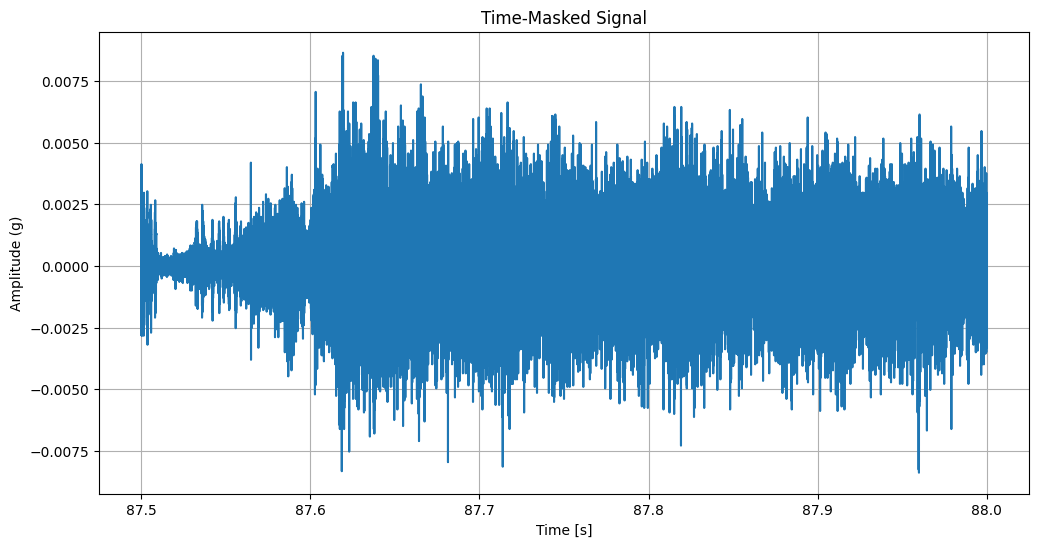

In [ ]:
start_time = 87.5
end_time = 88

original_or_synthetic = ""
while True:
    # Specify whether to generate the scalogram using the orignal or synthetic data
    original_or_synthetic = input("Specify whether to generate the scalogram using the orignal or synthetic data. Type \"original\" or \"synthetic\": ")
    print(original_or_synthetic)

    if original_or_synthetic == "original" or original_or_synthetic == "synthetic":
        break
    else:
        raise Exception("Invalid input. Try again.")

if original_or_synthetic == "original":
    # Process original signal
    mask = (combined_data[:, 0] > start_time)
    if end_time is not None:
        mask = (combined_data[:, 0] > start_time) & (combined_data[:, 0] < end_time)
    time = combined_data[:, 0][mask]
    signal = combined_data[:, 1][mask]
    signal = signal - np.mean(signal)  # Remove any y-axis offset

elif original_or_synthetic == "synthetic":
    # Synthetic signal (for comparison)
    mask = (time_synthetic > start_time)
    if end_time is not None:
        mask = (time_synthetic > start_time) & (time_synthetic < end_time)
    time = time_synthetic[mask]
    signal = synthetic_signal[mask]

print(time.shape)
print(signal.shape)


# Plot Time-Masked Raw Signal
plt.figure(figsize=(12, 6))
plt.plot(time, signal)
plt.title(f'Time-Masked Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (g)')
plt.grid(True)
plt.show()

## Filter the Signal for Wavelet Analysis (Optional)

In [ ]:
filter_signal = ""
while filter_signal != "y":
    # Specify the file path directly
    filter_signal = input("Would you like to filter the signal? (Y/n)")

    if filter_signal.lower() == "y":
        # Define the bandpass filter parameters
        lowcut = 100  # Lower frequency (Hz)
        highcut = 25000  # Upper frequency (Hz)

        # Butterworth bandpass filter design
        def butter_bandpass(lowcut, highcut, fs, order=20):
            nyquist = 0.5 * fs  # Nyquist frequency
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = scipy.signal.butter(order, [low, high], btype='band')
            return b, a

        # Apply the filter to the signal
        def bandpass_filter(data, lowcut, highcut, fs, order=5):
            b, a = butter_bandpass(lowcut, highcut, fs, order=order)
            y = scipy.signal.filtfilt(b, a, data)
            return y

        # Filter the signal
        signal = bandpass_filter(signal, lowcut, highcut, sampling_frequency) 
        break

    elif filter_signal.lower() == "n":
        break

if filter_signal == "y":
    # Plot the filtered signal
    plt.figure(figsize=(12, 6))
    plt.plot(time, signal, color="r")
    plt.title(f'Complete Filtered Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

    # Plot the filtered signal (zoomed in)
    zoom_mask = (time > start_time) & (time < (start_time + .02))

    plt.figure(figsize=(12, 6))
    plt.plot(time[zoom_mask], signal[zoom_mask], color="r")
    plt.title(f'Filtered Signal (Zoomed)')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

    # Re-compute and plot the power spectrum for the filtered signal
    psd_frequencies, psd = welch(signal, fs=sampling_frequency, nperseg=8192)
    # Convert PSD to dB Scale
    psd_db = 10 * np.log10(psd)

    psd_min = np.min(psd)
    psd_max = np.max(psd)

    psd_db_min = np.min(psd_db)
    psd_db_max = np.max(psd_db)

    # Plotting the PSD on a log scale
    plt.figure(figsize=(6,3))
    plt.semilogx(psd_frequencies, psd_db)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (V^2/Hz)")
    # plt.ylim([psd_db_min, psd_db_max])
    plt.title("Power Spectral Density, Unfiltered (PSD)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

## Compute Wavelet Transform

In [ ]:
# Listing all available wavelets
all_wavelets = pywt.wavelist()  # Lists all discrete and continuous wavelets
discrete_wavelets = pywt.wavelist(kind='discrete')
continuous_wavelets = pywt.wavelist(kind='continuous')

print("Discrete wavelets:", discrete_wavelets)
print("Continuous wavelets:", continuous_wavelets)

# Declare the mother wavelet
wavelet = 'morl'
wavelet_obj = pywt.ContinuousWavelet(wavelet)
print()
print(wavelet_obj)

Discrete wavelets: ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']
Continuous wave

In [ ]:
# Define the frequency range you want to capture
lowest_frequency = 1000  # Hz (adjust this as needed)
highest_frequency = min(150e3, sampling_frequency/2)  # Nyquist frequency (adjust this as needed -- max is Nyquist/2)

# Compute the normalized frequency range
lowest_frequency_normalized = lowest_frequency / sampling_frequency
highest_frequency_normalized = highest_frequency / sampling_frequency

# Calculate the corresponding scales
highest_scale = pywt.frequency2scale(wavelet, lowest_frequency_normalized)
lowest_scale = pywt.frequency2scale(wavelet, highest_frequency_normalized)
# scales = np.arange(1, 128)

num_scales = 128  # Adjustable resolution

normalized_frequencies = np.linspace(highest_frequency_normalized, lowest_frequency_normalized, num_scales)
scales = [pywt.frequency2scale(wavelet, frequency) for frequency in normalized_frequencies]

scales_converted2frequencies = [pywt.scale2frequency(wavelet, scale)/sample_interval for scale in scales]
print(f"Scales: {scales}")
print(f"Scales converted to frequencies: {scales_converted2frequencies}")

# Perform the Continuous Wavelet Transform
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=sample_interval)

# Verify the frequency range
print(f"Frequency range: {frequencies[-1]:.2f} Hz to {frequencies[0]:.2f} Hz")

Scales: [5.416666666666667, 5.45936722924713, 5.502746373720137, 5.546820405310972, 5.591606155846971, 5.637121005189839, 5.683382903723288, 5.7304103959571275, 5.778222645313025, 5.8268394601615, 5.876281321184511, 5.9265694101430135, 5.977725640134399, 6.029772687430609, 6.082734024994106, 6.136633957775796, 6.191497659906397, 6.2473512139008305, 6.3042216520039105, 6.362136999815031, 6.421126322339765, 6.481219772627347, 6.542448643165103, 6.604845420213787, 6.6684438412821505, 6.733278955954323, 6.799387190300474, 6.866806415119452, 6.935576018282028, 7.005736981465137, 7.077331961591222, 7.15040537731273, 7.225003500910237, 7.30117455600368, 7.3789688215102975, 7.458438742320202, 7.539639047201519, 7.622626874492132, 7.707461906184643, 7.7942065110657905, 7.882925897631781, 7.9736882775674225, 8.066565040650408, 8.161630942023255, 8.258964302865376, 8.358647225597409, 8.46076582486061, 8.565410475637087, 8.672676080013447, 8.782662354242914, 8.895474137931034, 9.011221727360056, 9

## CWT Results

In [ ]:
abs_coefficients = np.abs(coefficients)  # Take the absolute value of the coefficients to get the magnitude
# print(coefficients)
# print(abs_coefficients)
abs_coefficients_copy = np.abs(coefficients)
power = np.abs(coefficients) ** 2
epsilon = 1e-10
power_db = 10 * np.log10(power+epsilon)

print(f"Frequencies Array: {frequencies.shape}")
print(f"Coefficients Array: {coefficients.shape}")

max_coeff_value = abs(coefficients.max())
print(f"Maximum Coefficients Value: {max_coeff_value}")
min_power = power.min()
max_power = power.max()
min_power_db = power_db.min()
print(f"Min Power: {min_power_db}")
max_power_db = power_db.max()
print(f"Max Power: {max_power_db}")

Frequencies Array: (128,)
Coefficients Array: (128, 499999)
Maximum Coefficients Value: 0.06734190366770508
Min Power: -99.99999999999993
Max Power: -23.421797190040287


## Full Scalogram Plotted with Filled Contours Method (adjust max_magnitude as needed for contrast)

In [ ]:
# Create a meshgrid for time and frequencies
time_mesh, freq_mesh = np.meshgrid(time, frequencies)

# Adjust the values for max_magnitude and n_color_contours to manipulate graph contrast and resolution, respectively
min_value = min_power_db
max_value = max_power_db
print(f"Min Scalogram Value: {min_value}")
print(f"Max Scalogram Value: {max_value}")
n_color_contours = 10

full_scalogram_levels = np.linspace(min_value, max_value, n_color_contours, endpoint=True)

Min Scalogram Value: -99.99999999999993
Max Scalogram Value: -23.421797190040287


masked_power_db shape: (128, 499999)
1000.0000000000001 150000.0
[150000.         148826.77165354 147653.54330709 146480.31496063
 145307.08661417 144133.85826772 142960.62992126 141787.4015748
 140614.17322835 139440.94488189 138267.71653543 137094.48818898
 135921.25984252 134748.03149606 133574.80314961 132401.57480315
 131228.34645669 130055.11811024 128881.88976378 127708.66141732
 126535.43307087 125362.20472441 124188.97637795 123015.7480315
 121842.51968504 120669.29133858 119496.06299213 118322.83464567
 117149.60629921 115976.37795276 114803.1496063  113629.92125984
 112456.69291339 111283.46456693 110110.23622047 108937.00787402
 107763.77952756 106590.5511811  105417.32283465 104244.09448819
 103070.86614173 101897.63779528 100724.40944882  99551.18110236
  98377.95275591  97204.72440945  96031.49606299  94858.26771654
  93685.03937008  92511.81102362  91338.58267717  90165.35433071
  88992.12598425  87818.8976378   86645.66929134  85472.44094488
  84299.21259843  83125.984

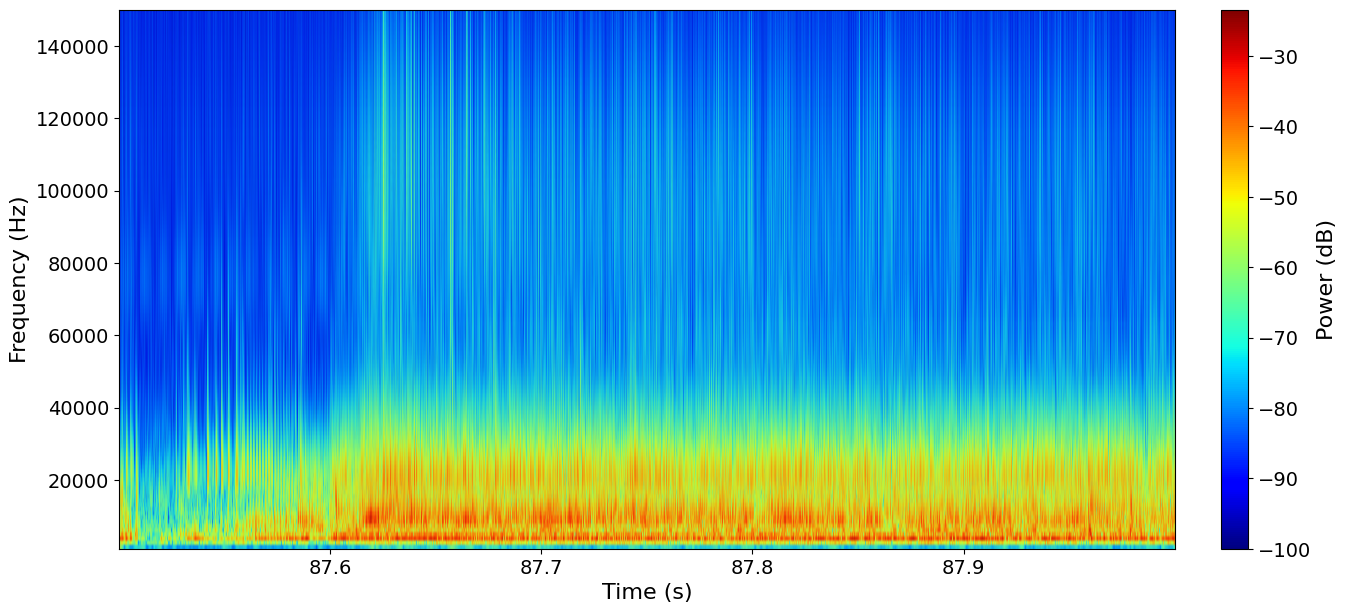

In [ ]:
title_size = 18
label_size = 16
tick_size = 14

# Find the indices of frequencies within the desired range
frequency_indices = np.where((frequencies >= lowest_frequency) & (frequencies <= highest_frequency))[0]

# Ensure frequency_indices is 1D and properly formatted
frequency_indices = np.ravel(frequency_indices)

# Filter the frequencies and coefficients accordingly
masked_frequencies = frequencies[frequency_indices]

# Specify the desired timeframe range
start_timeframe = start_time
end_timeframe = end_time
# start_timeframe = 205
# end_timeframe = 210

# Find the indices of the time within the desired range
if end_timeframe is not None:
    time_indices = np.where((time >= start_timeframe) & (time <= end_timeframe))[0]
else:
    time_indices = np.where((time >= start_timeframe))[0]

# Ensure time_indices is 1D and properly formatted
time_indices = np.ravel(time_indices)

masked_timeframe = time[time_indices]

# Corrected indexing for power_db
# Using frequency_indices and time_indices to slice power_db
masked_power_db = power_db[np.ix_(frequency_indices, time_indices)]
print("masked_power_db shape:", masked_power_db.shape)


fig, ax1 = plt.subplots(figsize=(16, 7))

# TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
scalogram_image = ax1.imshow(
    masked_power_db, 
    extent=[masked_timeframe[0], masked_timeframe[-1], masked_frequencies[-1], masked_frequencies[0]],  # TODO: I think the y-scale is messed up on the graph because the y-axis of masked_power_db is not linear 
    # interpolation='bilinear', 
    cmap='jet', 
    aspect='auto', 
    vmax=max_value, 
    vmin=min_value
)

print(masked_frequencies[-1], masked_frequencies[0])

print(masked_frequencies)

ax1.set_ylabel('Frequency (Hz)', fontsize=label_size)
ax1.set_xlabel('Time (s)', fontsize=label_size)
# ax1.set_title('FL-98 (Heavy 2-Phase Flow) Scalogram', fontsize=title_size)

# Format the y-axis to show whole numbers instead of scientific notation
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# ax2 = ax1.twinx()
# ax2.set_yscale('log')
# ax2.set_ylabel('Scales')
# ax2.tick_params(axis='y', color='b')
# ax2.set_ylim(scales[0], scales[-1])
# ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

cbar = fig.colorbar(scalogram_image, ax=[ax1], fraction=0.05, pad=0.04)
cbar.set_label('Power (dB)', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size) 

plt.tick_params(axis='both', which='major', labelsize=tick_size)

In [ ]:
raise Exception()

Exception: 

In [ ]:
# # Find the indices of frequencies within the desired range
# frequency_indices = np.where((frequencies >= lowest_frequency) & (frequencies <= highest_frequency))[0]

# # Ensure frequency_indices is 1D and properly formatted
# frequency_indices = np.ravel(frequency_indices)

# # Filter the frequencies and coefficients accordingly
# masked_frequencies = frequencies[frequency_indices]

# print("power_db shape:", power_db.shape)  # (16, 1279999)
# print("frequency_indices:", frequency_indices)  # Should be 1D array

# # Specify the desired timeframe range
# start_timeframe = start_time
# end_timeframe = end_time
# # start_timeframe = 205
# # end_timeframe = 210

# # Find the indices of the time within the desired range
# if end_timeframe is not None:
#     time_indices = np.where((time >= start_timeframe) & (time <= end_timeframe))[0]
# else:
#     time_indices = np.where((time >= start_timeframe))[0]

# # Ensure time_indices is 1D and properly formatted
# time_indices = np.ravel(time_indices)

# masked_timeframe = time[time_indices]

# print("time_indices:", time_indices)  # Should be 1D array

# # Corrected indexing for power_db
# # Using frequency_indices and time_indices to slice power_db
# masked_power_db = power_db[np.ix_(frequency_indices, time_indices)]
# print(power_db)

# print("masked_power_db shape:", masked_power_db.shape)


# fig, ax1 = plt.subplots(figsize=(16, 8))

# # TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
# scalogram_image = ax1.pcolormesh(
#     time, frequencies, masked_power_db, 
#     cmap='jet',
#     shading='gouraud',  # or 'flat' if you want exact cell boundaries
#     vmax=max_value,
#     vmin=min_value
# )

# ax1.set_ylabel('Frequency (Hz)')
# ax1.set_xlabel('Time (s)')
# ax1.set_title('Scalogram (Wavelet Transform)')

# # Format the y-axis to show whole numbers instead of scientific notation
# ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# ax2 = ax1.twinx()
# ax2.set_ylabel('Scales')
# ax2.tick_params(axis='y', color='b')
# ax2.set_ylim(scales[0], scales[-1])
# ax2.invert_yaxis()

# # Adjust the space between the graph and colorbar
# plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# cbar = fig.colorbar(scalogram_image, ax=[ax1, ax2], fraction=0.05, pad=0.04)
# cbar.set_label('Power (dB)')

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.contourf(time, frequencies, power_db, levels=full_scalogram_levels, cmap='jet', extend='both')
# scalogram = ax1.pcolormesh(time, frequencies, power_db, cmap='jet', shading='auto')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
# ax1.set_yscale('log')
# ax1.set_xlim([1, 1.05])

ax2 = ax1.twinx()
# ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Power')

# # Create a third axis to plot "time" vs "signal" with a linear y-axis
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Move the third axis further out
# ax3.set_ylabel('Signal', color='g')
# ax3.plot(time, signal, color='g')  # Plot time vs signal
# ax3.tick_params(axis='y', labelcolor='g')
# ax3.set_yscale('linear')  # Ensure the y-axis is linear

plt.show()

## Time-Masked Scalogram (adjust xmin, xmax, max_magnitude to zoom and adjust contrast)

In [ ]:
xmin = 43.02  # Default 0
xmax = xmin + 0.01  # Use none to designate no end
n_color_contours = 64

mask = time > xmin
if xmax:
    mask = mask & (time < xmax)

masked_time_array = time[mask]
masked_power_array = power[:, mask]
masked_power_db_array = power_db[:, mask]
masked_signal = signal[mask]

levels = np.linspace(min_value, max_value, n_color_contours, endpoint=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

zoom_mask = (time > xmin) & (time < xmax)
ax.plot(time[zoom_mask], signal[zoom_mask])

# Adjust the space between the graph and the right edge to match the contourf() plot
plt.subplots_adjust(right=0.85)

plt.show()



fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.contourf(masked_time_array, frequencies, masked_power_db_array, levels=levels, cmap='jet', extend='both')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Power')

plt.show()

In [ ]:
# # Define the bandpass filter parameters
# lowcut = 1000  # Lower frequency (Hz)
# highcut = 5000  # Upper frequency (Hz)

# # Butterworth bandpass filter design
# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyquist = 0.5 * fs  # Nyquist frequency
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = scipy.signal.butter(order, [low, high], btype='band')
#     return b, a

# # Apply the filter to the signal
# def bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = scipy.signal.filtfilt(b, a, data)
#     return y

# # Filter the signal
# filtered_signal = bandpass_filter(signal, lowcut, highcut, sampling_frequency)

# plt.figure(figsize=(10, 6))
# plt.plot(time[zoom_mask], filtered_signal[zoom_mask], label='Filtered Signal (Bandpass)', color='r')
# plt.title(f'Filtered Signal (Bandpass: {lowcut}Hz - {highcut}Hz)')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

## Statistical Analysis of Time-Masked Signal

In [ ]:
N = np.size(masked_signal)
mean = np.mean(masked_signal)
variance = np.var(masked_signal)  # Population variance
st_dev = math.sqrt(variance)
shapiro_test = stats.shapiro(masked_signal)
ks_test = stats.kstest(masked_signal, 'norm')
anderson_test = stats.anderson(masked_signal, dist='norm')

print(f"# of Points: {N}")
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Shapiro Test p-value: {shapiro_test.pvalue}")
print(f"K-S Test p-value: {ks_test.pvalue}")
print(anderson_test)

# # Create a histogram
# plt.figure(figsize=(12,5))
# plt.hist(signal, bins=200, edgecolor='black', alpha=0.7)
# plt.title('Histogram of the Data Distribution')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.xlim([mean-3*st_dev,mean+3*st_dev])
# plt.show()

# # KDE plot to smooth over the low-resolution signal
# sns.kdeplot(signal, shade=True)
# plt.title('KDE Plot of Low-Resolution Signal')
# plt.xlabel('Value')
# plt.ylabel('Density')
# # plt.axvline(x=mean-2*st_dev, color='r', linestyle='--',)
# plt.axvline(x=mean-st_dev, color='r', linestyle='--',)
# plt.axvline(x=mean, color='r', linestyle='--',)
# plt.axvline(x=mean+st_dev, color='r', linestyle='--',)
# # plt.axvline(x=mean+2*st_dev, color='r', linestyle='--',)
# plt.show()

# Q-Q Plot: If the data is normally distributed, the points in the Q-Q plot will roughly follow a straight diagonal line.
stats.probplot(masked_signal, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [ ]:
# # Calculate mean and standard deviation
# mean = np.mean(signal)
# std_dev = np.std(signal)

# # Perform KDE using scipy's gaussian_kde
# kde = gaussian_kde(signal)

# # Create an x-axis range for plotting and integration
# x = np.linspace(min(signal), max(signal), 1000)

# # Evaluate the KDE for the x-axis
# kde_values = kde(x)

# # Plot the KDE
# plt.plot(x, kde_values, label='KDE')
# plt.fill_between(x, kde_values, alpha=0.5)

# # Add vertical lines for ±1σ, ±2σ, and ±3σ
# plt.axvline(mean - std_dev, color='green', linestyle='--', label='1σ')
# plt.axvline(mean + std_dev, color='green', linestyle='--')
# plt.axvline(mean - 2*std_dev, color='blue', linestyle='--', label='2σ')
# plt.axvline(mean + 2*std_dev, color='blue', linestyle='--')
# plt.axvline(mean - 3*std_dev, color='red', linestyle='--', label='3σ')
# plt.axvline(mean + 3*std_dev, color='red', linestyle='--')

# # Define the KDE function for integration
# def kde_function(x_val):
#     return kde(x_val)

# # Numerically integrate the KDE for 1σ, 2σ, and 3σ
# area_1sigma, _ = quad(kde_function, mean - std_dev, mean + std_dev)
# area_2sigma, _ = quad(kde_function, mean - 2*std_dev, mean + 2*std_dev)
# area_3sigma, _ = quad(kde_function, mean - 3*std_dev, mean + 3*std_dev)

# # Integrate the entire KDE (total area)
# total_area, _ = quad(kde_function, min(signal), max(signal))

# # Calculate the percentage of area within 1σ, 2σ, and 3σ
# percentage_within_1sigma = (area_1sigma / total_area) * 100
# percentage_within_2sigma = (area_2sigma / total_area) * 100
# percentage_within_3sigma = (area_3sigma / total_area) * 100

# # Add title and labels
# plt.title(f"KDE Plot with {percentage_within_1sigma:.2f}% within 1σ, "
#           f"{percentage_within_2sigma:.2f}% within 2σ, "
#           f"{percentage_within_3sigma:.2f}% within 3σ")
# plt.legend()

# # Show plot
# plt.show()

# # Print the results
# print(f"Percentage of area within 1 standard deviation: {percentage_within_1sigma:.2f}%")
# print(f"Percentage of area within 2 standard deviations: {percentage_within_2sigma:.2f}%")
# print(f"Percentage of area within 3 standard deviations: {percentage_within_3sigma:.2f}%")

In [ ]:
# Calculate the power spectrum of the wavelet transform (magnitude squared of coefficients)
power_spectrum = abs_coefficients_copy[:] ** 2

# Compute the mean power spectrum of the baseline
masked_mean_power_spectrum  = np.mean(masked_power_array, axis=1)

dof = 2  # DOF=2 because in a complex-valued signal, both the real and imaginary parts contribute to the power

# Using chi2.cdf to convert power spectrum values to confidence levels
# chi2.cdf returns the probability that a chi-squared random variable with 'dof' DOF 
# will be less than or equal to a given value (power in this case)
confidence_array = chi2.cdf(power_spectrum / masked_mean_power_spectrum[:, np.newaxis], dof)
masked_confidence_array = chi2.cdf(masked_power_array / masked_mean_power_spectrum[:, np.newaxis], dof)

# Compute the power levels corresponding to an n% confidence level at each frequency/scale
confidence_percentage = 99.0
confidence = confidence_percentage / 100
confidence_level_power = chi2.ppf(confidence, df=2) * masked_mean_power_spectrum

# Convert confidence level from power to magnitude by taking the square root
confidence_level_magnitude = np.sqrt(confidence_level_power)

"""Curve Fit for Noise Following a Power Law"""
# Mask Frequencies above the Sensor's Level of Attenuation
max_sensor_frequency = 10000
mask = frequencies < 10000

# Define the power-law function
def power_law(f, k, alpha):
    return k * f ** (-alpha)

# Initial guess for k and alpha
initial_guess = [1e-3, 1]

# Perform curve fitting
params, covariance = curve_fit(power_law, frequencies[mask], masked_mean_power_spectrum[mask], p0=initial_guess)
k_fitted, alpha_fitted = params
print(f"Fitted k: {k_fitted}")
print(f"Fitted alpha: {alpha_fitted}")

# Compute the fitted power values
P_fitted = power_law(frequencies, k_fitted, alpha_fitted)

# Plot the original data and the fitted curve
plt.figure()
plt.plot(frequencies, masked_mean_power_spectrum, label='Original Data')
plt.plot(frequencies, P_fitted, 'r', label='Fitted Curve')
plt.plot(frequencies, confidence_level_power, color='gray', alpha=0.3, label=f'{confidence_percentage}% Confidence Power')
plt.axvline(max_sensor_frequency, color='orange', linestyle='--', label="Max Sensor Frequency")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power vs. Frequency with Fitted Power Law')
plt.legend()
plt.show()

# Visualize the baseline power and the confidence intervals for reference
plt.plot(frequencies, masked_mean_power_spectrum, label='Mean Power')
plt.plot(frequencies, P_fitted, 'r', label='Fitted Curve')
plt.plot(frequencies, confidence_level_power, color='gray', alpha=0.3, label=f'{confidence_percentage}% Confidence Power')
plt.axvline(max_sensor_frequency, color='orange', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.xlim([0, 100])
plt.gca().set_ylim(bottom=0)
plt.show()

In [ ]:
# Get the confidences for every scale for a magnitude level on the scalogram
def get_confidence_levels(magnitude: float, mean_power_spectrum, dof=2):
    if magnitude > 1 or magnitude < 0:
        raise Exception("Magnitude must be a number between 0 and 1")
    n_scales = mean_power_spectrum.shape[0]
    magnitude_coefficients = np.full(n_scales, magnitude)
    power_spectrum = magnitude_coefficients ** 2
    confidence_levels = chi2.cdf(power_spectrum / mean_power_spectrum, dof)
    return confidence_levels

confidence_levels_for_certain_magnitude = get_confidence_levels(magnitude=0.01, mean_power_spectrum=masked_mean_power_spectrum)
np.set_printoptions(precision=15)
print(confidence_levels_for_certain_magnitude)
np.set_printoptions(precision=8)

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Overlay confidence contours (in magnitude)
scalogram = ax1.contourf(time, frequencies, power, levels=full_scalogram_levels, cmap='jet', extend='both')
# Overlay the single filled contour
contour = ax1.contourf(time, frequencies, confidence_array, levels=[0.999999999999998, 1], colors='white', alpha=.5)

ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Magnitude')
# ax1.set_xlim([12.2, 12.21])
plt.show()

## Full Scalogram Plotted with Colormesh Method

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.pcolormesh(time, frequencies, power, cmap='jet', shading='auto')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Magnitude')

plt.show()